In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = os.getcwd()   
parent = os.path.join(path, os.pardir) 
abspath = os.path.abspath(parent) 
PROJ_ROOT = os.path.join(abspath)
print(PROJ_ROOT)

c:\Users\CHARU\Pictures\ML\MLProjects


In [3]:
# pip install yfinance

In [4]:
import yfinance as yf

tickers = yf.Tickers('Msft')

tickers.tickers['MSFT'].info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'website': 'https://www.microsoft.com',
 'industry': 'Software - Infrastructure',
 'industryKey': 'software-infrastructure',
 'industryDisp': 'Software - Infrastructure',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops and supports software, services, devices and solutions worldwide. The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, and other office services. This segment also provides LinkedIn; and dynamics business solutions, including Dynamics 365, a set of intelligent, cloud-based applications across ERP, CRM, power 

In [5]:
data = yf.download("MSFT", start="2020-01-01")

[*********************100%%**********************]  1 of 1 completed


#### 1. Data Inspection

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1053 entries, 2020-01-02 to 2024-03-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1053 non-null   float64
 1   High       1053 non-null   float64
 2   Low        1053 non-null   float64
 3   Close      1053 non-null   float64
 4   Adj Close  1053 non-null   float64
 5   Volume     1053 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 57.6 KB


In [7]:
data.shape

(1053, 6)

In [8]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,154.493866,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570129,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964508,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569809,21634100
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984039,27746500


##### Observations:
1. There doesnt seem to be any preprocessing needed for above data as no Millions, Hundreds, Percentage or other symbols are used.
2. There is not a straightforward column for price which can be used for our time series analysis. Definitions of the present terms:
    1. Open Price: The price of the stock at the beginning of the time period.
    2. High Price: The highest traded price of the stock during the time period.
    3. Low Price: The lowest traded price of the stock during the time period.
    4. Close Price: The price of the stock at the end of the time period.
    From the above, the **Close price** seems to be the most appropriate for time series modelling.
    Thus, proceeding ahead with it.

#### 2. Data Visualization and check for stationarity

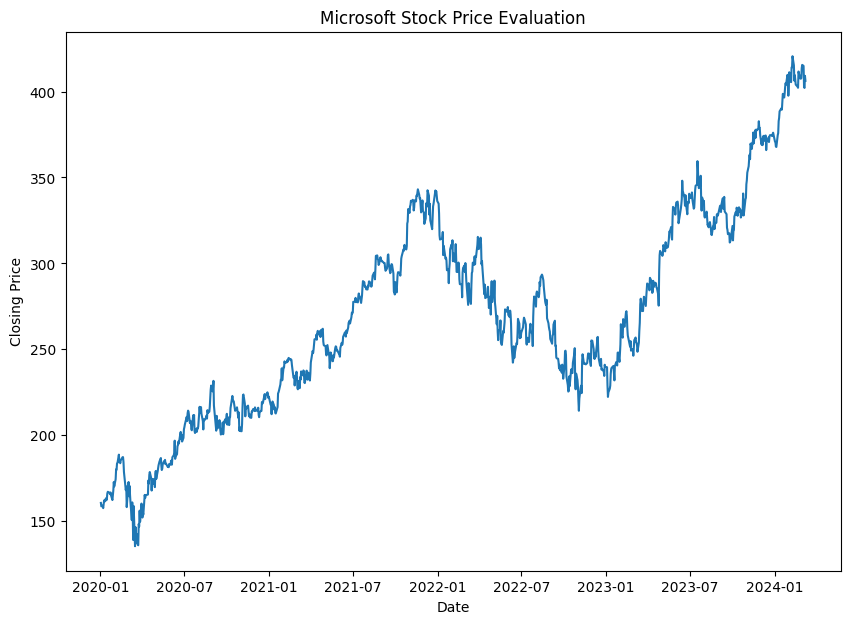

In [9]:
plt.figure(figsize=(10,7))
plt.plot(data['Close'])
plt.title('Microsoft Stock Price Evaluation')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

The series does not seem to have stationarity.

In [10]:
# pip install statsmodels


In [11]:
from statsmodels.tsa.stattools import adfuller

# Checking for stationarity ( Augmented Dickey Fuller test)
def dickey_fuller_test(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Value: {result[4]}')
    if result[1] > 0.05:
        print(f'The time series is not stationary!!! Further action needed!')
    else:
        print(f'The time series is stationary! No further action needed!')

# Applying to our series
dickey_fuller_test(data['Close'])

ADF Statistics: -0.7117574778948543
p-value: 0.8436805353461467
Critical Value: {'1%': -3.436635203238866, '5%': -2.8643150683130307, '10%': -2.568247558190521}
The time series is not stationary!!! Further action needed!


As proved from visualization and the Dickey Fuller test , we need to make the series stationary so we will start with differentiating.

In [12]:
# Keeping a copy of original dataframe so that dont need to download again
df = data[['Close']].copy()
df

,Close
Date,
2020-01-02,160.619995
2020-01-03,158.619995
2020-01-06,159.029999
2020-01-07,157.580002
2020-01-08,160.089996
...,...
2024-03-04,414.920013
2024-03-05,402.649994
2024-03-06,402.089996


In [13]:
df['Close_Diff'] = df['Close'].diff()
df


,Close,Close_Diff
Date,,
2020-01-02,160.619995,NaN
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
...,...,...
2024-03-04,414.920013,-0.579987
2024-03-05,402.649994,-12.270020
2024-03-06,402.089996,-0.559998


In [14]:
import numpy as np

# dropna not working directly so need following
df = df.dropna(how='any')
df


,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2024-03-04,414.920013,-0.579987
2024-03-05,402.649994,-12.270020
2024-03-06,402.089996,-0.559998


In [15]:
# Again check for stationarity
dickey_fuller_test(df['Close_Diff'])

ADF Statistics: -10.557564188308355
p-value: 7.879946368562442e-19
Critical Value: {'1%': -3.436635203238866, '5%': -2.8643150683130307, '10%': -2.568247558190521}
The time series is stationary! No further action needed!


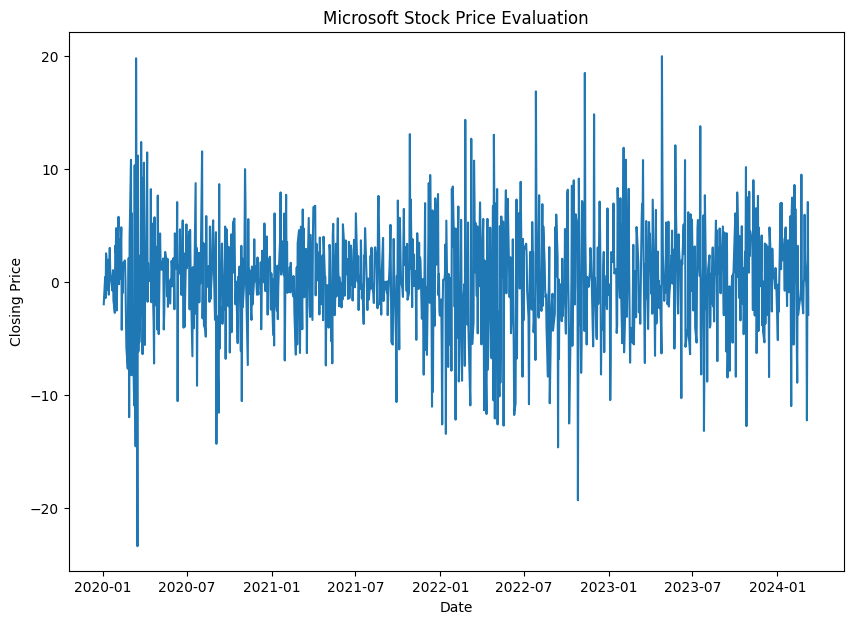

In [16]:
plt.figure(figsize=(10,7))
plt.plot(df['Close_Diff'])
plt.title('Microsoft Stock Price Evaluation')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

Now series is stationary , proceeding ahead. 

#### 3. Splitting data into train and test

In [17]:
# Taking 80 % as training
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [18]:
print(f'Training size = {train.shape[0]} and Testing size = {test.shape[0]}')

Training size = 841 and Testing size = 211


In [19]:
train_index = train.shape[0]
test_index = test.shape[0]

#### 4. Now applying AR Model

To apply the AR model, we need to choose the lag order. For this, we can use ACF and PACF plots. The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are commonly used in time series analysis to determine the appropriate lag order for Autoregressive (AR) models. These plots help you identify the number of lags that have a significant correlation with the current observation.

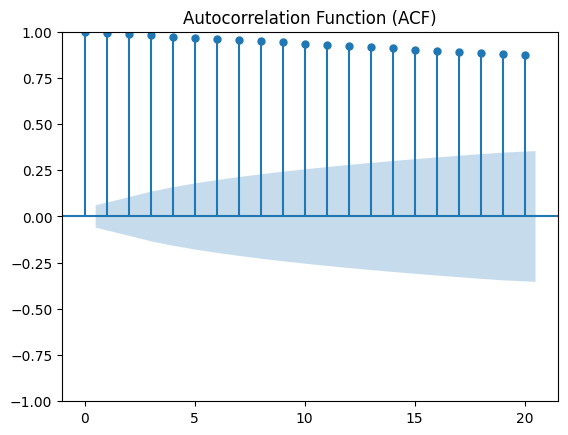

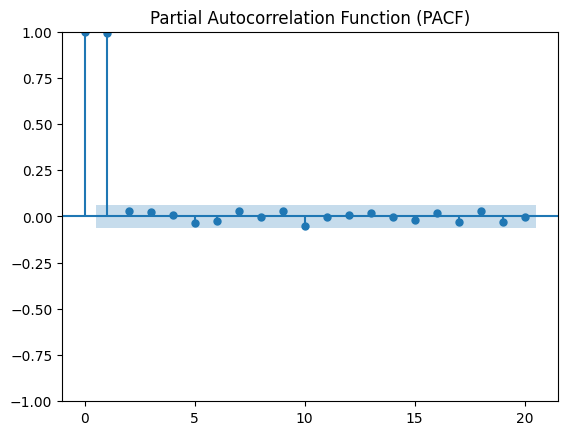

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Close'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data['Close'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

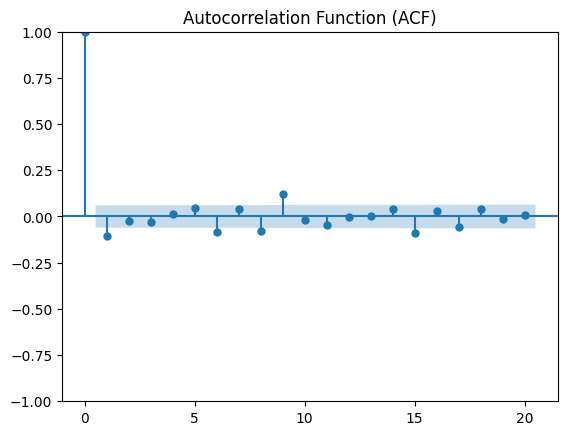

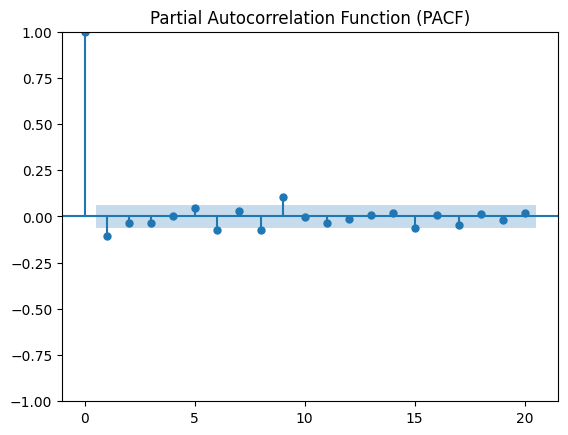

In [21]:
# Plotting the diffs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Close_Diff'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(df['Close_Diff'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

As the ACF and PACF are almost similar, we know that an ARMA(p,q) model will be a better fit for this use case. 
So we will apply a number of AR models to see what would be a good lag value.

And the value of p and q determined from ACF and PACF graphs is 1 and 1.

In [22]:
# Now applying Auto Regression AR model
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.ar_model import AutoReg

# Fit models with different lag orders
for p in range(1, 20):
    model = AutoReg(df['Close'], lags=p)
    model_fit = model.fit()
    print(f'Lag Order {p}: AIC={model_fit.aic}, BIC={model_fit.bic}')

Lag Order 1: AIC=6304.237206919039, BIC=6319.109699031669
Lag Order 2: AIC=6290.194079978058, BIC=6310.020261750664
Lag Order 3: AIC=6285.704192976392, BIC=6310.482156018374
Lag Order 4: AIC=6281.346019598684, BIC=6311.073852787969
Lag Order 5: AIC=6278.197702475366, BIC=6312.87349195146
Lag Order 6: AIC=6272.679230615526, BIC=6312.301059772524
Lag Order 7: AIC=6264.150412757948, BIC=6308.716362237538
Lag Order 8: AIC=6260.101784912618, BIC=6309.6099325970445
Lag Order 9: AIC=6251.255305662097, BIC=6305.703726667106
Lag Order 10: AIC=6236.010978404312, BIC=6295.397745072071
Lag Order 11: AIC=6233.02472830705, BIC=6297.347910199045
Lag Order 12: AIC=6228.676351060037, BIC=6297.934014949932
Lag Order 13: AIC=6225.545406014685, BIC=6299.7356158811735
Lag Order 14: AIC=6222.525291141754, BIC=6301.646108161367
Lag Order 15: AIC=6219.01192910282, BIC=6303.061411642722
Lag Order 16: AIC=6211.642280459879, BIC=6300.618484070628
Lag Order 17: AIC=6208.288277508408, BIC=6302.189254916698
Lag Ord

Taking lag order as 10 as proper AIC and BIC value

In [23]:
final_ar_model = AutoReg(train['Close'], lags=10)
ar_model_fit = final_ar_model.fit()

print(ar_model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  841
Model:                    AutoReg(10)   Log Likelihood               -2484.676
Method:               Conditional MLE   S.D. of innovations              4.812
Date:                Sun, 10 Mar 2024   AIC                           4993.352
Time:                        15:18:15   BIC                           5050.024
Sample:                            10   HQIC                          5015.084
                                  841                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7153      0.936      1.833      0.067      -0.119       3.549
Close.L1       0.9136      0.034     26.482      0.000       0.846       0.981
Close.L2       0.0548      0.046      1.179      0.2

In [24]:
train

,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2023-05-01,305.559998,-1.700012
2023-05-02,305.410004,-0.149994
2023-05-03,304.399994,-1.010010


In [25]:
test_data = df[['Close', 'Close_Diff']].iloc[train_size+1:]
test_data

,Close,Close_Diff
Date,,
2023-05-09,307.000000,-1.649994
2023-05-10,312.309998,5.309998
2023-05-11,310.109985,-2.200012
2023-05-12,308.970001,-1.139984
2023-05-15,309.459991,0.489990
...,...,...
2024-03-04,414.920013,-0.579987
2024-03-05,402.649994,-12.270020
2024-03-06,402.089996,-0.559998


In [26]:
test

,Close,Close_Diff
Date,,
2023-05-08,308.649994,-2.000000
2023-05-09,307.000000,-1.649994
2023-05-10,312.309998,5.309998
2023-05-11,310.109985,-2.200012
2023-05-12,308.970001,-1.139984
...,...,...
2024-03-04,414.920013,-0.579987
2024-03-05,402.649994,-12.270020
2024-03-06,402.089996,-0.559998


In [27]:
data.Close

Date
2020-01-02    160.619995
2020-01-03    158.619995
2020-01-06    159.029999
2020-01-07    157.580002
2020-01-08    160.089996
                 ...    
2024-03-04    414.920013
2024-03-05    402.649994
2024-03-06    402.089996
2024-03-07    409.140015
2024-03-08    406.220001
Name: Close, Length: 1053, dtype: float64

In [28]:
test_series = test_data.iloc[:, 0]
print(test_series)

Date
2023-05-09    307.000000
2023-05-10    312.309998
2023-05-11    310.109985
2023-05-12    308.970001
2023-05-15    309.459991
                 ...    
2024-03-04    414.920013
2024-03-05    402.649994
2024-03-06    402.089996
2024-03-07    409.140015
2024-03-08    406.220001
Name: Close, Length: 210, dtype: float64


In [29]:
test_diff_series = test_data.iloc[:, 1]
print(test_diff_series)

Date
2023-05-09    -1.649994
2023-05-10     5.309998
2023-05-11    -2.200012
2023-05-12    -1.139984
2023-05-15     0.489990
                ...    
2024-03-04    -0.579987
2024-03-05   -12.270020
2024-03-06    -0.559998
2024-03-07     7.050018
2024-03-08    -2.920013
Name: Close_Diff, Length: 210, dtype: float64


In [30]:
train_series = train.iloc[:, 0]
print(train_series)

Date
2020-01-03    158.619995
2020-01-06    159.029999
2020-01-07    157.580002
2020-01-08    160.089996
2020-01-09    162.089996
                 ...    
2023-05-01    305.559998
2023-05-02    305.410004
2023-05-03    304.399994
2023-05-04    305.410004
2023-05-05    310.649994
Name: Close, Length: 841, dtype: float64


In [31]:
train_diff_series = train.iloc[:, 1]
print(train_diff_series)

Date
2020-01-03   -2.000000
2020-01-06    0.410004
2020-01-07   -1.449997
2020-01-08    2.509995
2020-01-09    2.000000
                ...   
2023-05-01   -1.700012
2023-05-02   -0.149994
2023-05-03   -1.010010
2023-05-04    1.010010
2023-05-05    5.239990
Name: Close_Diff, Length: 841, dtype: float64


In [32]:
# Predict on test set
# model = AutoReg(train_diff_series, lags=1)
# results = model.fit()

diff_forecast = ar_model_fit.predict(start=train_index, end=train_index + test_index - 1)
diff_forecast

# Reversing the differencing to obtain predictions in original scale
# predictions = df['Close_Diff'].shift(1) + predictions
predictions = diff_forecast
predictions

841     308.246595
842     309.868277
843     310.185416
844     310.471381
845     310.040630
           ...    
1047    289.978826
1048    289.924796
1049    289.871066
1050    289.817634
1051    289.764499
Length: 211, dtype: float64

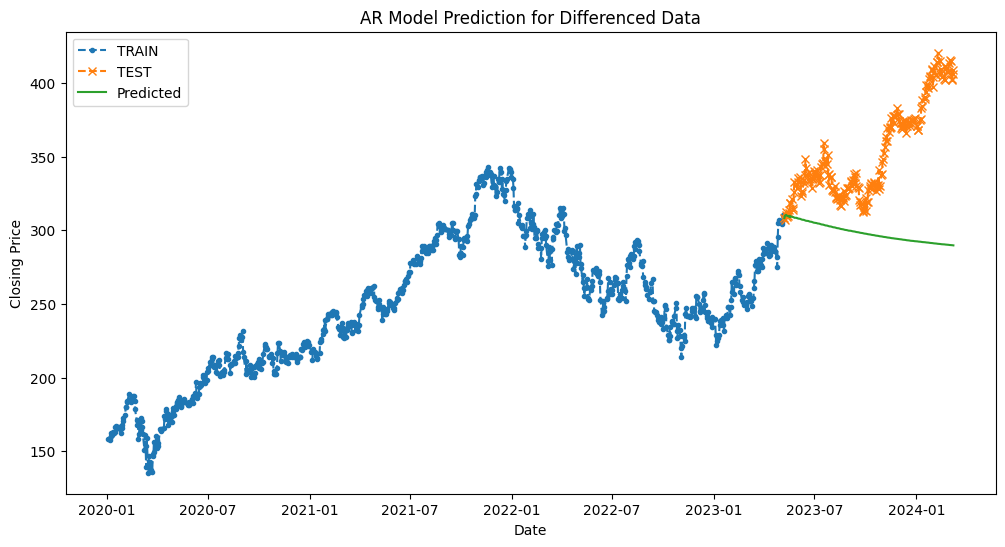

In [33]:
# Plot actual vs. predicted values
ar_predictions_df = pd.DataFrame({'Close': predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=ar_predictions_df, label="Predicted")

plt.title('AR Model Prediction for Differenced Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


**Evaluating above model**

In [34]:
import math
from sklearn.metrics import mean_squared_error

# Calculate the Root Mean Squared Error (RMSE)
# predictions.fillna(0, inplace=True)
mse = math.sqrt(mean_squared_error(test['Close'], ar_predictions_df['Close']))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 65.78484591661521


#### 5. Now proceeding with ARIMA model

For parameters p, d and q, 
1. d is the differencing term which has already been decided as 1 as 1 differencing itself leads to a stationary series.
2. For p and q terms, we saw in earlier ACF and PACF graphs which are almost similar so both values will be equal and
   the order is 1 as only after that, do the lags go out of the significant limit.

In [35]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Close'], order = (1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  841
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2521.854
Date:                Sun, 10 Mar 2024   AIC                           5049.709
Time:                        15:18:19   BIC                           5063.909
Sample:                             0   HQIC                          5055.151
                                - 841                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2889      0.246      1.173      0.241      -0.194       0.772
ma.L1         -0.3859      0.242     -1.597      0.110      -0.859       0.088
sigma2        23.7249      0.915     25.932      0.0

OBS: 
The Prob(Q) value is  0.95, which means the residuals are uncorrelated.
But, the Prob(JB) is 0 meaning the residuals might not have gaussian normal distribution. 
We can check from following plot:

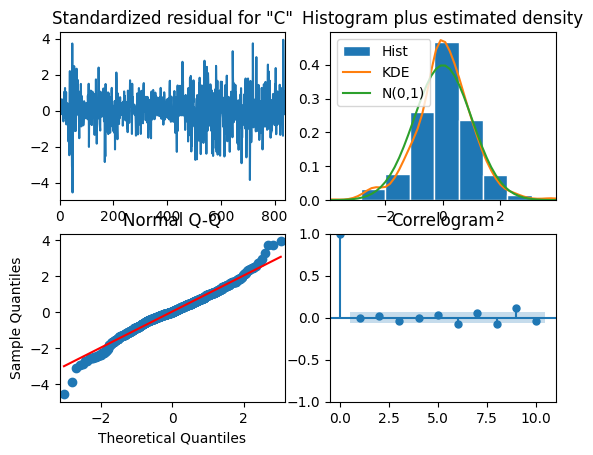

In [36]:
model_fit.plot_diagnostics()
plt.show()

Now as finalized values of p,q and d, we can actually go ahead with our train, test data and do the prediction, forecasting and calculate performance metrics.

In [37]:
# Making model from only training data
arima_model = ARIMA(train['Close_Diff'], order=(1,1,1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_Diff   No. Observations:                  841
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2524.981
Date:                Sun, 10 Mar 2024   AIC                           5055.962
Time:                        15:18:22   BIC                           5070.162
Sample:                             0   HQIC                          5061.404
                                - 841                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0981      0.027     -3.683      0.000      -0.150      -0.046
ma.L1         -0.9998      0.041    -24.614      0.000      -1.079      -0.920
sigma2        23.7091      1.308     18.120      0.0

In [38]:
# Predict on test set
arima_predictions = model_fit.predict(start=train_index, end=train_index + test_index - 1)
arima_predictions

841     310.115899
842     309.961591
843     309.917009
844     309.904129
845     309.900407
           ...    
1047    309.898895
1048    309.898895
1049    309.898895
1050    309.898895
1051    309.898895
Name: predicted_mean, Length: 211, dtype: float64

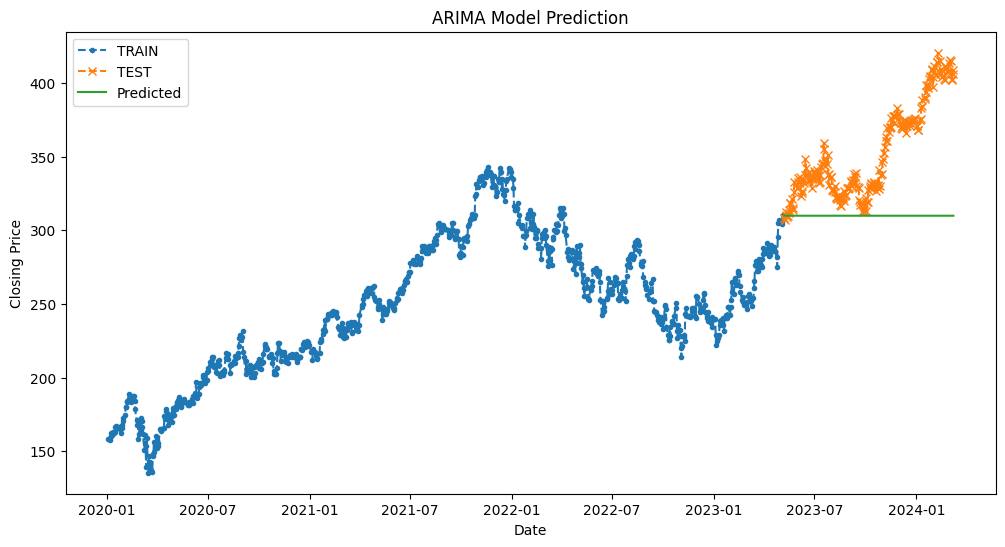

In [39]:
# Plot actual vs. predicted values

arima_predictions = pd.DataFrame({'Close': arima_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=arima_predictions, label="Predicted")

plt.title('ARIMA Model Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [40]:
import math
from sklearn.metrics import mean_squared_error

# Calculate the Root Mean Squared Error (RMSE)
# arima_predictions.fillna(0, inplace=True)
mse = math.sqrt(mean_squared_error(test['Close'], arima_predictions['Close']))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 53.430146809533866


#### 6. SARIMA model

Now we need to check for seasonality. This we will do with the help of **decomposition**. We will break it down into 3:
1. Trend: Overall direction in TS.
2. Seasonality: Predictable and repeated pattern repeating after any amount of time.
3. White Noise: Random components.

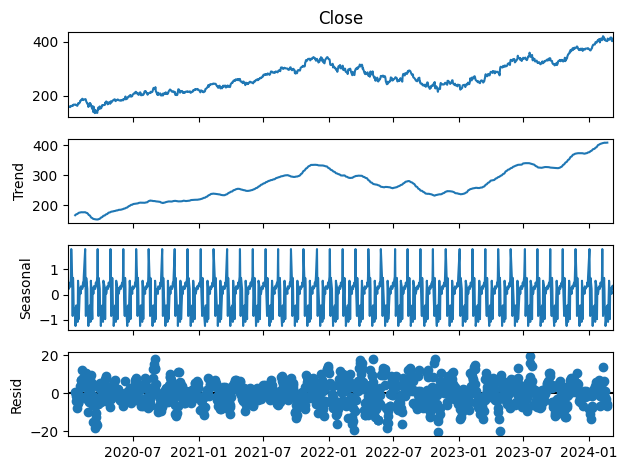

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(data['Close'], period=25)
decomp_results.plot()
plt.show()

We see that there is overall upward trend. And also see that there is seasonality in data. So can proceed ahead with SARIMA model. 
We will go ahead with differenced data as it is stationary.

In [42]:
!pip install pmdarima

In [43]:
train

,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2023-05-01,305.559998,-1.700012
2023-05-02,305.410004,-0.149994
2023-05-03,304.399994,-1.010010


In [44]:
from pmdarima import auto_arima

# Use auto_arima to find the best SARIMA model
auto_model = auto_arima(train['Close'], seasonal=True, m=10, trace=True, suppress_warnings=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[10] intercept   : AIC=5055.751, Time=4.85 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=5055.136, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=5049.528, Time=1.49 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=5049.255, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=5054.284, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[10] intercept   : AIC=5048.620, Time=0.50 sec
 ARIMA(0,1,1)(1,0,0)[10] intercept   : AIC=5049.270, Time=2.12 sec
 ARIMA(0,1,1)(1,0,1)[10] intercept   : AIC=5051.241, Time=2.63 sec
 ARIMA(1,1,1)(0,0,0)[10] intercept   : AIC=5050.153, Time=1.11 sec
 ARIMA(0,1,2)(0,0,0)[10] intercept   : AIC=5050.486, Time=1.19 sec
 ARIMA(1,1,0)(0,0,0)[10] intercept   : AIC=5048.841, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[10] intercept   : AIC=5051.139, Time=1.95 sec
 ARIMA(0,1,1)(0,0,0)[10]             : AIC=5048.046, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[10]             : AIC=5048.782, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1

In [45]:
# Now applying the SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train['Close'], order=(0,1,1), seasonal_order=(0,0,1,10))
sarima_results = sarima.fit()
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  841
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 10)   Log Likelihood               -2521.386
Date:                            Sun, 10 Mar 2024   AIC                           5048.771
Time:                                    15:19:01   BIC                           5062.971
Sample:                                         0   HQIC                          5054.214
                                            - 841                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0974      0.028     -3.509      0.000      -0.152      -0.043
ma.S.L10      -0.0396      0.030   

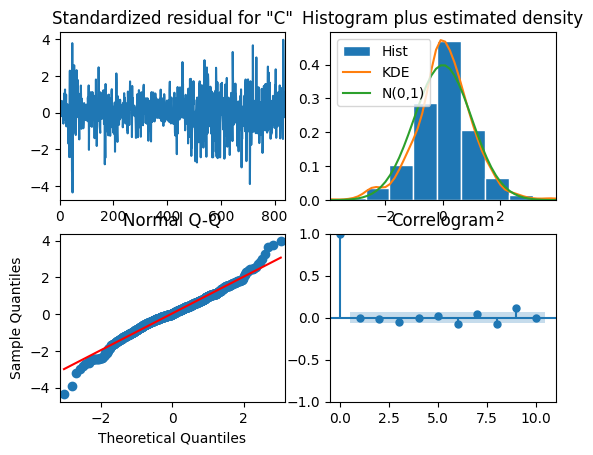

In [46]:
# Now plotting common diagnostics
sarima_results.plot_diagnostics()
plt.show()

In [47]:
# Predict on test set
sarima_predictions = sarima_results.predict(start=train_index, end=train_index + test_index - 1)

# Reversing the differencing to obtain predictions in original scale
# final_predictions = test_series.iloc[-1] + sarima_predictions
sarima_predictions

841     310.293675
842     310.555863
843     309.764298
844     309.379102
845     309.288368
           ...    
1047    309.174669
1048    309.174669
1049    309.174669
1050    309.174669
1051    309.174669
Name: predicted_mean, Length: 211, dtype: float64

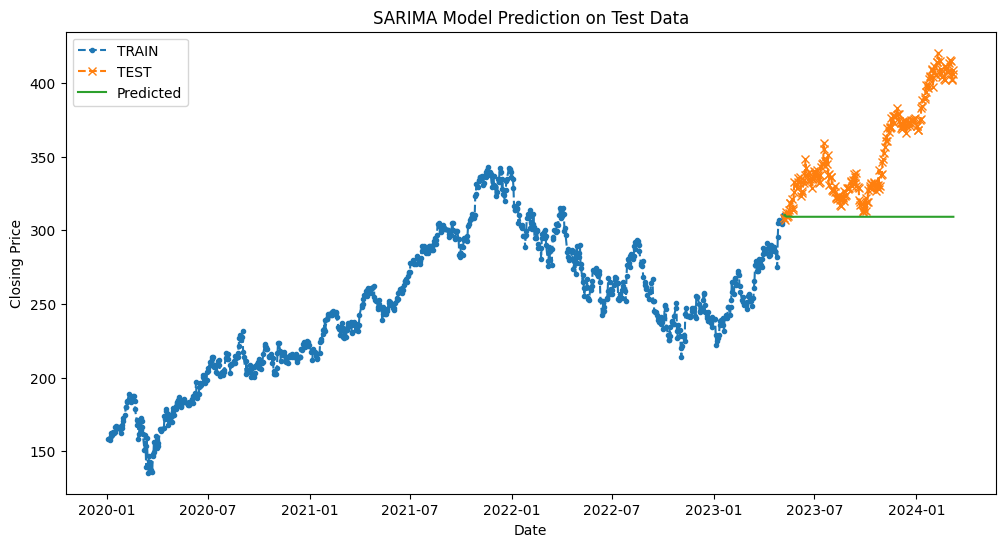

In [48]:
# Plot the actual vs. predicted values on the test set

sarima_prediction = pd.DataFrame({'Close': sarima_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=sarima_prediction, label="Predicted")

plt.title('SARIMA Model Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [49]:
# Evaluate model performance
mse = math.sqrt(mean_squared_error(test['Close'], sarima_prediction['Close']))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 54.01497076312541


In [50]:
train

,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2023-05-01,305.559998,-1.700012
2023-05-02,305.410004,-0.149994
2023-05-03,304.399994,-1.010010


#### 6. Exponential Smoothing
1. Single ES

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exponential_smoothing_model = ExponentialSmoothing(train['Close'], seasonal='add', seasonal_periods=7)
es_model_fit = exponential_smoothing_model.fit()

In [52]:
train_index, test_index

(841, 211)

In [53]:
# Make predictions on the test set
predictions = es_model_fit.predict(start=train_index, end=train_index + test_index - 1)
predictions

841     309.956695
842     309.646343
843     309.889406
844     309.867721
845     308.926958
           ...    
1047    309.867721
1048    308.926958
1049    309.940761
1050    310.168148
1051    309.956695
Length: 211, dtype: float64

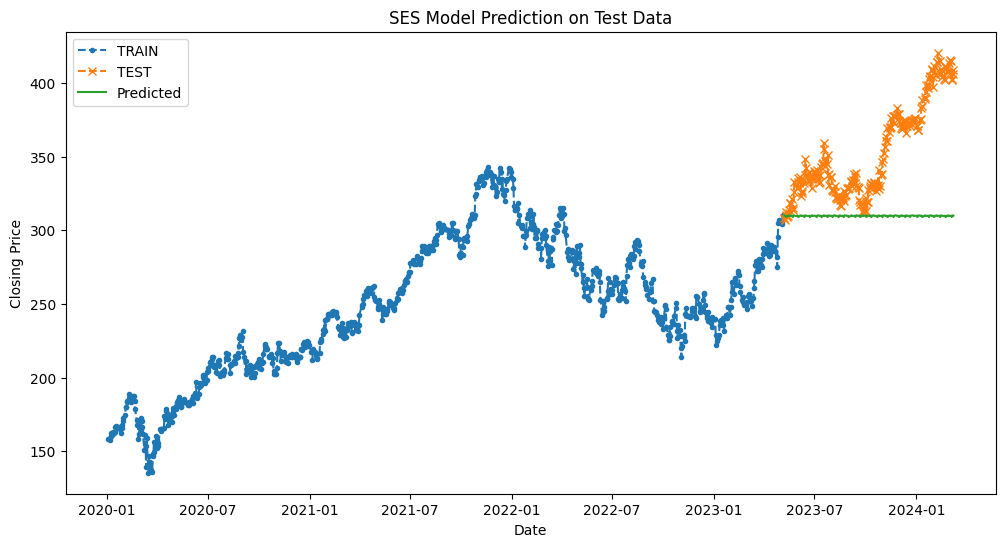

In [54]:
# Plot the actual vs. predicted values on the test set

ses_predictions = pd.DataFrame({'Close': predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=ses_predictions, label="Predicted")

plt.title('SES Model Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


2. Double ES

In [55]:
# Double Exponential Smoothing (Holt's method)
holt_model = ExponentialSmoothing(train['Close'], trend='add', seasonal=None, damped=False)
holt_fit = holt_model.fit()
holt_predictions = holt_fit.predict(start=train_index, end=train_index + test_index - 1)

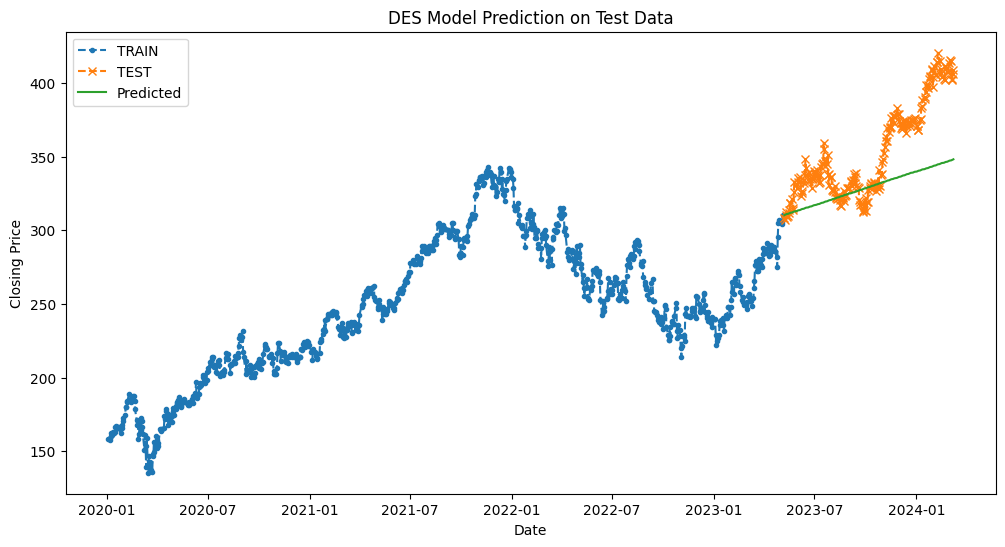

In [56]:
# Plot the actual vs. predicted values on the test set

des_predictions = pd.DataFrame({'Close': holt_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=des_predictions, label="Predicted")

plt.title('DES Model Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


3. Triple ES

In [57]:
# Triple Exponential Smoothing (Holt-Winters' method)
holt_winters_model = ExponentialSmoothing(train['Close'], trend='add', seasonal='add', seasonal_periods=7, damped=False)
holt_winters_fit = holt_winters_model.fit()
holt_winters_predictions = holt_winters_fit.predict(start=train_index, end=train_index + test_index - 1)


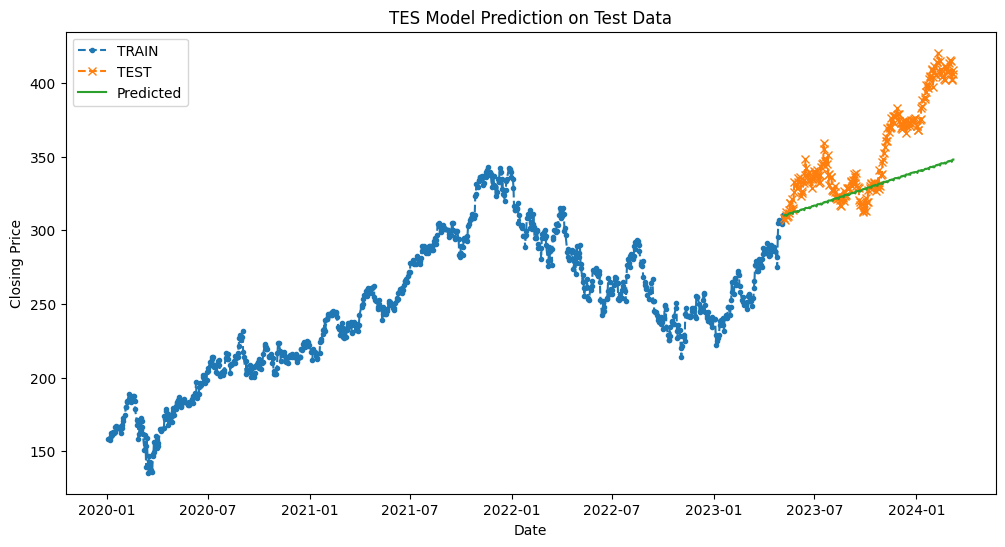

In [58]:
# Plot the actual vs. predicted values on the test set

tes_predictions = pd.DataFrame({'Close': holt_winters_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=tes_predictions, label="Predicted")

plt.title('TES Model Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [59]:
# Evaluating SES model performance
mse = math.sqrt(mean_squared_error(test['Close'], ses_predictions['Close']))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 53.53328696190868


In [60]:
# Evaluating DES model performance
mse = math.sqrt(mean_squared_error(test['Close'], des_predictions['Close']))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 32.98722435720296


In [61]:
# Evaluating TES model performance
mse = math.sqrt(mean_squared_error(test['Close'], tes_predictions['Close']))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 33.22850136469355


#### 8. FB Prophet

In [62]:
!pip install pystan

In [63]:
# Make input readable by FB Prophet
# ds: date and y: price/close
train_prophet = pd.DataFrame({'ds': train.index, 'y': train.Close})
test_prophet = pd.DataFrame({'ds': test.index, 'y':test.Close})

In [64]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(train_prophet)

15:19:23 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
# Make future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

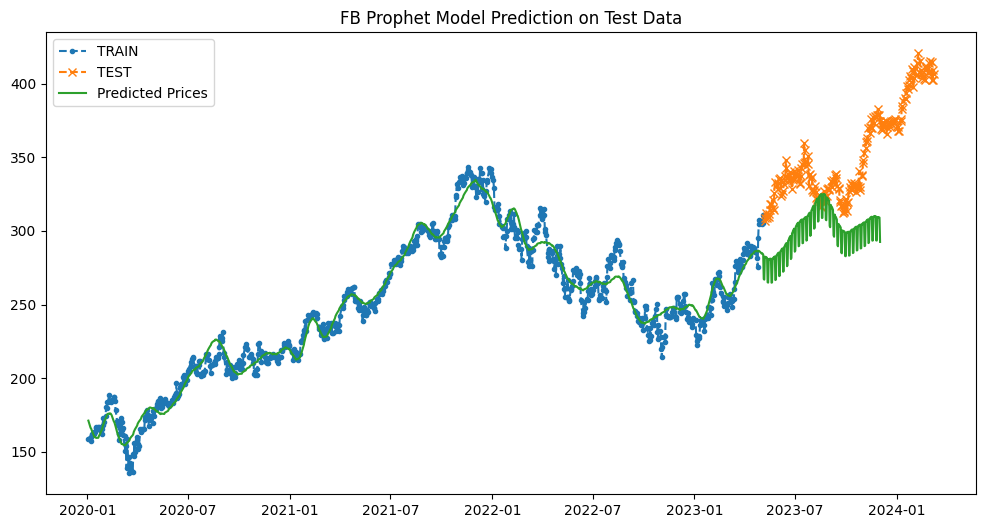

In [66]:
# Plot the actual vs. predicted values on the test set

# tes_predictions = pd.DataFrame({'Close': holt_winters_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test_prophet['ds'], test_prophet['y'], label="TEST", marker='x', linestyle='--')
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted Prices")

plt.title('FB Prophet Model Prediction on Test Data')
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [67]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-03,180.087795,159.723900,183.058573,180.087795,180.087795,-8.926325,-8.926325,-8.926325,4.792735,4.792735,4.792735,-13.719060,-13.719060,-13.719060,0.0,0.0,0.0,171.161470
1,2020-01-06,179.366127,156.970379,178.895555,179.366127,179.366127,-11.815264,-11.815264,-11.815264,4.454390,4.454390,4.454390,-16.269654,-16.269654,-16.269654,0.0,0.0,0.0,167.550864
2,2020-01-07,179.125571,153.695744,177.379801,179.125571,179.125571,-12.894411,-12.894411,-12.894411,4.241442,4.241442,4.241442,-17.135852,-17.135852,-17.135852,0.0,0.0,0.0,166.231161
3,2020-01-08,178.885016,154.922324,177.100572,178.885016,178.885016,-13.124818,-13.124818,-13.124818,4.858577,4.858577,4.858577,-17.983396,-17.983396,-17.983396,0.0,0.0,0.0,165.760197
4,2020-01-09,178.644460,152.923622,175.799861,178.644460,178.644460,-13.947904,-13.947904,-13.947904,4.847396,4.847396,4.847396,-18.795300,-18.795300,-18.795300,0.0,0.0,0.0,164.696556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,2023-11-28,311.271045,262.416243,355.195006,266.270055,358.221392,-2.325226,-2.325226,-2.325226,4.241442,4.241442,4.241442,-6.566668,-6.566668,-6.566668,0.0,0.0,0.0,308.945818
1048,2023-11-29,311.439749,262.517569,359.320934,266.264908,358.905946,-2.035769,-2.035769,-2.035769,4.858577,4.858577,4.858577,-6.894346,-6.894346,-6.894346,0.0,0.0,0.0,309.403980
1049,2023-11-30,311.608453,261.728899,360.225449,266.301910,359.484372,-2.379869,-2.379869,-2.379869,4.847396,4.847396,4.847396,-7.227265,-7.227265,-7.227265,0.0,0.0,0.0,309.228584
1050,2023-12-01,311.777157,261.527109,360.607581,266.068538,359.976451,-2.766190,-2.766190,-2.766190,4.792735,4.792735,4.792735,-7.558926,-7.558926,-7.558926,0.0,0.0,0.0,309.010967


In [68]:
test_prophet

,ds,y
Date,,
2023-05-08,2023-05-08,308.649994
2023-05-09,2023-05-09,307.000000
2023-05-10,2023-05-10,312.309998
2023-05-11,2023-05-11,310.109985
2023-05-12,2023-05-12,308.970001
...,...,...
2024-03-04,2024-03-04,414.920013
2024-03-05,2024-03-05,402.649994
2024-03-06,2024-03-06,402.089996


In [69]:
forecast[-len(test_prophet):]['yhat']

841     267.252908
842     266.872402
843     282.554735
844     281.990590
845     282.281187
           ...    
1047    308.945818
1048    309.403980
1049    309.228584
1050    309.010967
1051    292.465851
Name: yhat, Length: 211, dtype: float64

In [70]:
# Performance metric evaluation
mse = math.sqrt(mean_squared_error(test_prophet['y'], forecast[-len(test_prophet):]['yhat']))
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 63.47017950081604


In [71]:
test_final = prophet_model.predict(test_prophet)


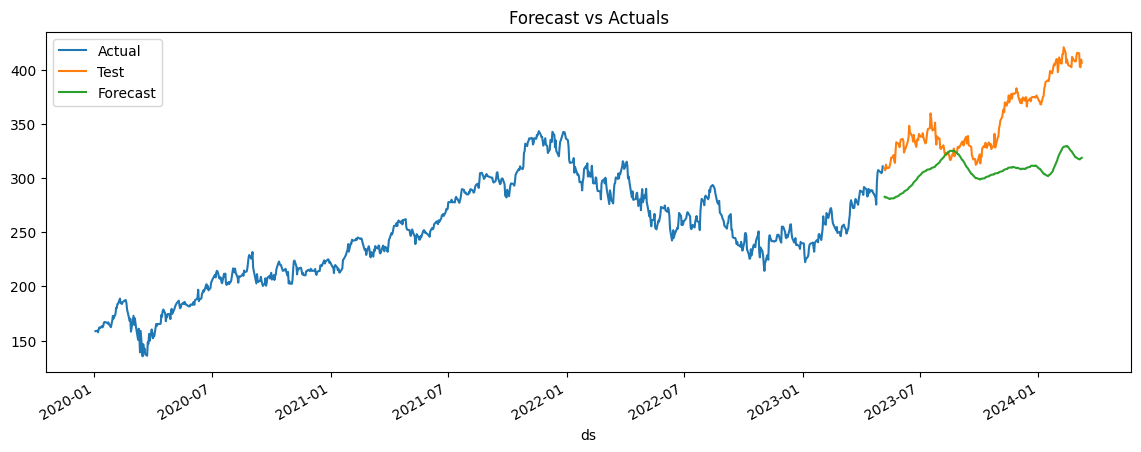

In [72]:
#plot results
f, ax = plt.subplots(figsize=(14,5))
train_prophet.plot(kind='line',x='ds', y='y', label='Actual', ax=ax)
test_prophet.plot(kind='line',x='ds',y='y',label='Test', ax=ax)
test_final.plot(kind='line',x='ds',y='yhat',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [73]:
# Performance metric evaluation
mse = math.sqrt(mean_squared_error(test_prophet['y'], test_final[-len(test_prophet):]['yhat']))
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 53.50259992812408


In [74]:
pip install prophet --no-binary :all:

Note: you may need to restart the kernel to use updated packages.


#### 9. LSTM

LSTMs are sensitive to scale, so we will normalize our inputs

In [75]:
df

,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2024-03-04,414.920013,-0.579987
2024-03-05,402.649994,-12.270020
2024-03-06,402.089996,-0.559998


In [76]:
df2 = pd.DataFrame({'Close': df['Close']})
df2

,Close
Date,
2020-01-03,158.619995
2020-01-06,159.029999
2020-01-07,157.580002
2020-01-08,160.089996
2020-01-09,162.089996
...,...
2024-03-04,414.920013
2024-03-05,402.649994
2024-03-06,402.089996


In [77]:
from sklearn.preprocessing import MinMaxScaler

mscaler = MinMaxScaler(feature_range = (0,1))
df_minmax_scaled = mscaler.fit_transform(np.array(df2).reshape(-1,1))
df_minmax_scaled.shape

(1052, 1)

In [78]:
len(df2)

1052

In [79]:
train_data= df2[0:train_size]
train_data

,Close
Date,
2020-01-03,158.619995
2020-01-06,159.029999
2020-01-07,157.580002
2020-01-08,160.089996
2020-01-09,162.089996
...,...
2023-05-01,305.559998
2023-05-02,305.410004
2023-05-03,304.399994


In [80]:
test_data = df2[train_size:len(df2)]
test_data

,Close
Date,
2023-05-08,308.649994
2023-05-09,307.000000
2023-05-10,312.309998
2023-05-11,310.109985
2023-05-12,308.970001
...,...
2024-03-04,414.920013
2024-03-05,402.649994
2024-03-06,402.089996


In [81]:
# preparing data for LSTM
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [82]:
test

,Close,Close_Diff
Date,,
2023-05-08,308.649994,-2.000000
2023-05-09,307.000000,-1.649994
2023-05-10,312.309998,5.309998
2023-05-11,310.109985,-2.200012
2023-05-12,308.970001,-1.139984
...,...,...
2024-03-04,414.920013,-0.579987
2024-03-05,402.649994,-12.270020
2024-03-06,402.089996,-0.559998


In [83]:
class Result:
    """Result is an object used to store the LSTM model variation created alongwith the 
       datasets created according to time basis like weekly , monthly and the history 
    """
    def __init__(self, model, dataframe_x, df_y, df_xtest, df_ytest, history):
        self.model = model
        self.dataframe_x = dataframe_x
        self.df_y = df_y
        self.df_xtest = df_xtest
        self.df_ytest = df_ytest
        self.history = history

In [84]:
!pip3 install tensorflow


In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

def create_lstm(n_steps, n_features, X_train, y_train, X_test, y_test, no_of_epochs):
    # n_features = 1
    # X, y = prepare_data(train_data['Close'], n_steps)
    
    # # reshape from [samples, timesteps] into [samples, timesteps, features]
    # X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # X_test, y_test = prepare_data(test_data['Close'], n_steps)
    
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error',  run_eagerly=True)
    # fit model
    history_lstm = model.fit(X_train, y_train, epochs=no_of_epochs, validation_data=(X_test, y_test), batch_size=64, verbose=1)

    return model, history_lstm

### Creating <i>Weekly</i> predictions

In [126]:
# Creating LSTM for weekly data
# result_weekly = create_lstm(train_data, test_data, 7) 

# Creating LSTM for weekly data
n_features = 1
n_steps = 7
X, y = prepare_data(train_data['Close'], n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

X_test, y_test = prepare_data(test_data['Close'], n_steps)

result_weekly, history_weekly = create_lstm(n_steps, n_features, X, y, X_test, y_test, 200)

Epoch 1/200
14/14 [==============================] - 4s 305ms/step - loss: 18178.1973 - val_loss: 2634.2617
Epoch 2/200
14/14 [==============================] - 3s 197ms/step - loss: 349.4999 - val_loss: 359.5145
Epoch 3/200
14/14 [==============================] - 3s 180ms/step - loss: 102.9236 - val_loss: 82.5405
Epoch 4/200
14/14 [==============================] - 3s 211ms/step - loss: 64.6727 - val_loss: 54.7507
Epoch 5/200
14/14 [==============================] - 4s 302ms/step - loss: 58.0790 - val_loss: 46.7001
Epoch 6/200
14/14 [==============================] - 4s 318ms/step - loss: 53.0545 - val_loss: 64.1042
Epoch 7/200
14/14 [==============================] - 4s 293ms/step - loss: 55.8162 - val_loss: 54.5256
Epoch 8/200
14/14 [==============================] - 4s 304ms/step - loss: 50.2210 - val_loss: 64.0191
Epoch 9/200
14/14 [==============================] - 3s 228ms/step - loss: 49.1957 - val_loss: 45.8669
Epoch 10/200
14/14 [==============================] - 3s 211ms/st

In [87]:

def plot_losses(history):
    plt.plot(history.history["loss"], label="training loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.show()

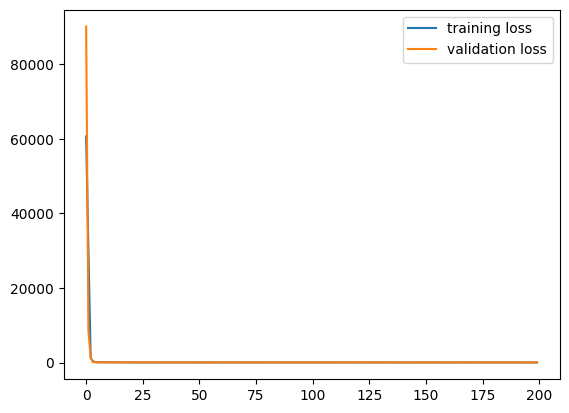

In [88]:
plot_losses(result_weekly.history)

In [121]:
train_data.shape

(841, 1)

In [117]:
test_data.shape

(211, 1)

In [123]:
X_test.shape

(210, 1)

In [129]:
def prediction_report(lstm_model, X_train, y_train, X_test, y_test, n_time, duration_type: str)-> np.array:
    #Lets predict and check performance metrics
    train_predict = lstm_model.predict(X_train)
    test_predict = lstm_model.predict(X_test)

    #Calculate RMSE performance metrics
    math.sqrt(mean_squared_error(y_train, train_predict))
    #Test Data RMSE
    rmse_ans = math.sqrt(mean_squared_error(y_test, test_predict))

    df1 = pd.DataFrame(train_data['Close'])
    df2 = pd.DataFrame(test_data['Close'])

    df = pd.concat([df1, df2])

    # Plot actual vs. predicted values
    # Shift train prediction for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:,:] = np.nan
    trainPredictPlot[n_time:len(train_predict) + n_time, :] = train_predict

    # Shift test prediction for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_predict) + (n_time * 2):len(df), :] = test_predict


    # Plot baseline and predictions

    lstm_predictions = pd.DataFrame({'Close': testPredictPlot.flatten(), 'Date': df.index})

    plt.figure(figsize=(15, 6))
    plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
    plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
    plt.plot('Date', 'Close', data=lstm_predictions , label="Predicted")

    plt.title('LSTM Model Prediction on {} Data'.format(duration_type))
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

    return testPredictPlot, rmse_ans

 6/27 [=====>........................] - ETA: 2s

7/7 [==============================] - 1s 82ms/step


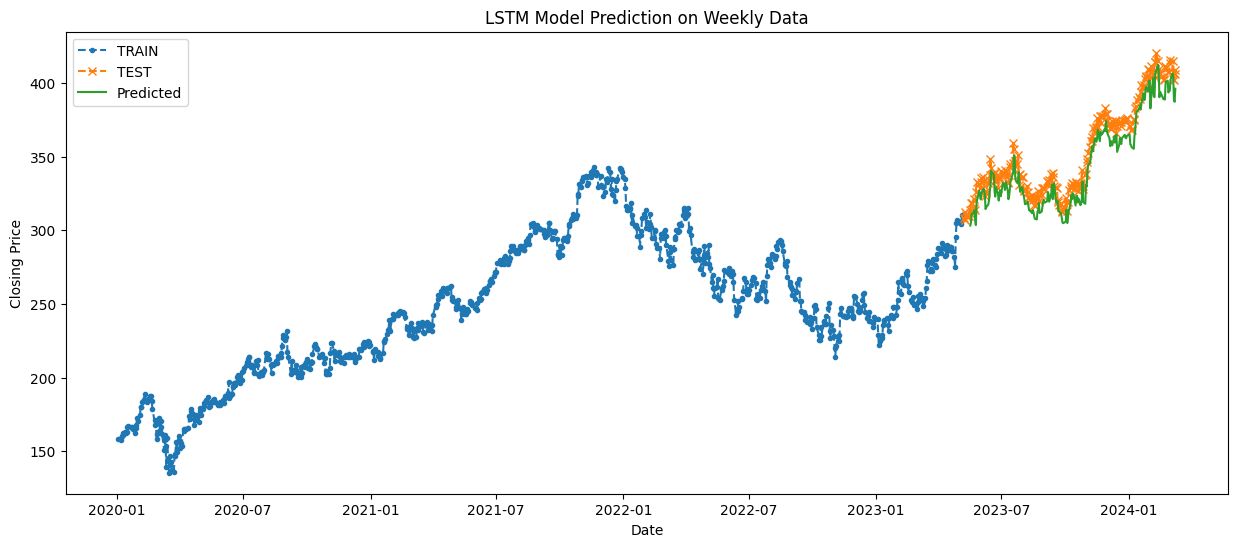

11.255815948252057

In [131]:
testPredictPlot, rmse_ans = prediction_report(result_weekly, X, y, X_test, y_test, 7, "Weekly")
rmse_ans

In [91]:
from src.utils import save_object
trained_model_file_path_for_weekly_LSTM=os.path.join("../model","lstm_weekly_model.pkl")
save_object(file_path=trained_model_file_path_for_weekly_LSTM, obj=result_weekly)

### Metric used to evaluate system: <u>Bollinger Bands</u>

Bollinger Bands belong among popular stock and cryptocurrency trading indicators. Bollinger Bands consist of 3 lines - price moving average for selected window (typically 20 datapoints), upper and lower Bollinger Band.

Upper and lower Bollinger bands are situated usually 2 standard deviations (sigma) above and below the moving average. Two sigma range means that the price will stay between Upper and Lower Bollinger band around 95% of the time. This can be used as a trading signal, since once price is outside the bands we have statistical outlier that is potentially actionable. Price above Upper Bollinger Band is considered overbought and conversely price below Lower band is considered oversold.

Bollinger Band definition from investopedia: https://www.investopedia.com/terms/b/bollingerbands.asp

In [91]:
# Calculating Bollinger Bands

In [92]:
weekly_data = data.iloc[1:]
weekly_data['lstm_weekly'] = testPredictPlot.flatten()
weekly_data


,Open,High,Low,Close,Adj Close,Volume,lstm_weekly
Date,,,,,,,
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570129,21116200,NaN
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964508,20813700,NaN
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569809,21634100,NaN
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984039,27746500,NaN
2020-01-09,161.839996,162.220001,161.029999,162.089996,155.907745,21385000,NaN
...,...,...,...,...,...,...,...
2024-03-04,413.440002,417.350006,412.320007,414.920013,414.920013,17596000,417.030487
2024-03-05,413.959991,414.250000,400.640015,402.649994,402.649994,26919200,413.777435
2024-03-06,402.970001,405.160004,398.390015,402.089996,402.089996,22344100,394.280975


### Goals:


1) Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. 

#### Starting with <u>WEEKLY</u> :

In [93]:

def plot_bollinger_bands(df: pd.DataFrame, buy_signal: list, sell_signal: list, hold_signal: list, model_name: str):
    fig, ax = plt.subplots(figsize=(16, 5))
    df['predictions'].plot(label='Predicted prices', linewidth=1.5)
    df['BU'].plot(label='Upper BB', linestyle='--', linewidth=1.5)
    df['B_MA'].plot(label='Middle BB', linestyle='--', linewidth=1.5)
    df['BL'].plot(label='Lower BB', linestyle='--', linewidth=1.5)
    
    plt.scatter(df.index, buy_signal, marker='^', color='tab:green', label='Buy', s=100)
    plt.scatter(df.index, np.absolute(sell_signal), marker='v', color='tab:red', label='Sell', s=100)
    plt.scatter(df.index, hold_signal, marker='*', color='tab:blue', label='Hold', s=100)

    plt.title(f'Bollinger Bands Strategy for {model_name} - Trading Signals', fontsize=20)
    plt.legend(loc='upper left')
    plt.show()


In [94]:
## Bollinger bands with ticks/ indications as to when to buy, hold or sell
def add_signal(data, is_daily, n, m, column):
     # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
     # adds two columns to dataframe with buy, hold and sell signals
    buy_list = []
    sell_list = []
    hold_list = []

    df = pd.DataFrame({"close": data['Close'][1:], "predictions": data[column][1:]})

    # df['predictions']= data[column]
    
    # takes one column from dataframe
    df['B_MA'] = df['predictions'].rolling(n).mean()
    df['B_STD'] = df['predictions'].rolling(n).std() # Rolling Standard deviation for intermediate calculation
    df['BU']  = df['B_MA'] + (df['B_STD'] * 2)
    df['BL']  = df['B_MA'] - (df['B_STD'] * 2)
    df = df.dropna()
    df = df.reset_index(drop = True)

    if is_daily:
        print("inside daily loop")
        for i in df.index:
            if df.loc[i, 'predictions'] > df.loc[i, 'BU']:         
                buy_list.append(np.nan)
                sell_list.append(df.loc[i, 'predictions'])
                hold_list.append(np.nan)

            elif df.loc[i, 'predictions'] < df.loc[i, 'BL']:        
                buy_list.append(df.loc[i, 'predictions'])
                sell_list.append(np.nan)  
                hold_list.append(np.nan)
            else:
                buy_list.append(np.nan)
                sell_list.append(np.nan)
                hold_list.append(df.loc[i, 'predictions'])
    else:
        print("inside non daily loop")         
        for i in df.index:
            if df.loc[i, 'predictions'] > df.loc[i, 'BU']:         
                buy_list.append(np.nan)
                sell_list.append(df.loc[i, 'predictions'])
                hold_list.append(np.nan)

            elif df.loc[i, 'predictions'] < df.loc[i, 'BL']:        
                buy_list.append(df.loc[i, 'predictions'])
                sell_list.append(np.nan)
                hold_list.append(np.nan)
  
            else:
                buy_list.append(np.nan)
                sell_list.append(np.nan)
                hold_list.append(df.loc[i, 'predictions'])

         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
    hold_list = pd.Series(hold_list, name = 'Hold')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
    df = df.join(hold_list)


    plot_bollinger_bands(df, buy_list, sell_list, hold_list, column)
    return df

inside non daily loop


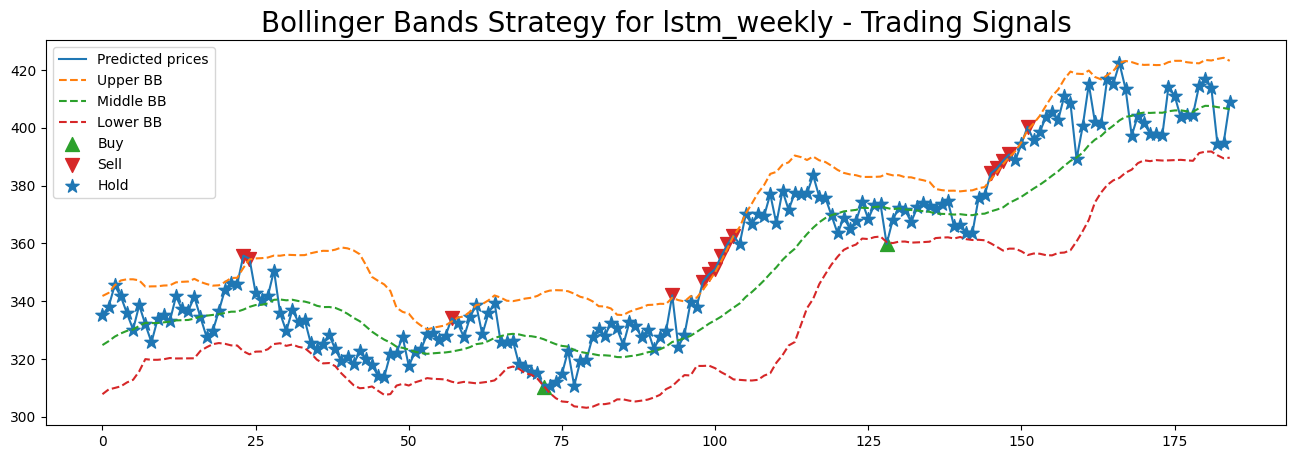

,close,predictions,B_MA,B_STD,BU,BL,Buy,Sell,Hold
0,337.339996,335.280518,324.838344,8.496517,341.831379,307.845309,NaN,NaN,335.280518
1,348.100006,338.079620,326.179735,8.355194,342.890122,309.469347,NaN,NaN,338.079620
2,342.329987,345.495087,327.759898,8.880871,345.521640,309.998157,NaN,NaN,345.495087
3,338.049988,341.656708,328.882338,9.157439,347.197215,310.567460,NaN,NaN,341.656708
4,333.559998,335.834290,329.759894,8.926307,347.612508,311.907279,NaN,NaN,335.834290
...,...,...,...,...,...,...,...,...,...
180,414.920013,417.030487,407.643127,7.935512,423.514151,391.772104,NaN,NaN,417.030487
181,402.649994,413.777435,407.577193,7.875579,423.328351,391.826034,NaN,NaN,413.777435
182,402.089996,394.280975,407.192525,8.337954,423.868433,390.516616,NaN,NaN,394.280975
183,409.140015,394.740173,406.868167,8.700519,424.269204,389.467130,NaN,NaN,394.740173


In [95]:
weekly_ans = add_signal(weekly_data, False, 20, 2, 'lstm_weekly')
weekly_ans

### Now <u> MONTHLY </u>:

In [96]:
# Creating LSTM for monthly data
# result_monthly = create_lstm(train_data, test_data, 30) 

n_features = 1
n_steps = 30
X, y = prepare_data(train_data['Close'], n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

X_test, y_test = prepare_data(test_data['Close'], n_steps)

result_monthly, history_monthly = create_lstm(n_steps, n_features, X, y, X_test, y_test, 200)

Epoch 1/200
13/13 [==============================] - 10s 737ms/step - loss: 1283630.6250 - val_loss: 739536.1875
Epoch 2/200
13/13 [==============================] - 9s 675ms/step - loss: 297062.0625 - val_loss: 430874.4375
Epoch 3/200
13/13 [==============================] - 8s 621ms/step - loss: 155528.6875 - val_loss: 243057.0000
Epoch 4/200
13/13 [==============================] - 21s 2s/step - loss: 118579.4688 - val_loss: 225903.2969
Epoch 5/200
13/13 [==============================] - 14s 1s/step - loss: 104704.0391 - val_loss: 175941.5156
Epoch 6/200
13/13 [==============================] - 12s 909ms/step - loss: 73210.8672 - val_loss: 91395.9375
Epoch 7/200
13/13 [==============================] - 14s 1s/step - loss: 32727.9375 - val_loss: 33464.6133
Epoch 8/200
13/13 [==============================] - 8s 646ms/step - loss: 5564.5591 - val_loss: 1863.4896
Epoch 9/200
13/13 [==============================] - 8s 652ms/step - loss: 1686.3993 - val_loss: 1713.8262
Epoch 10/200
13/

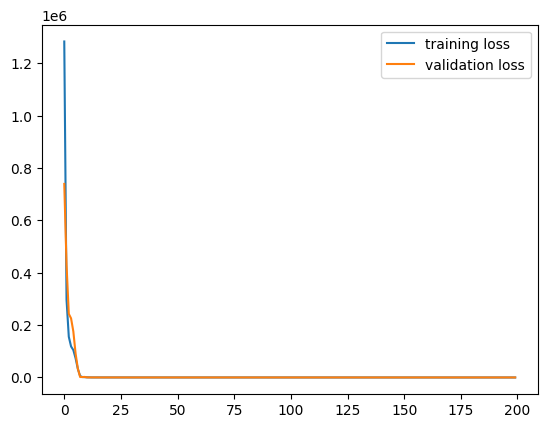

In [98]:
plot_losses(result_monthly.history)


6/6 [==============================] - 1s 228ms/step


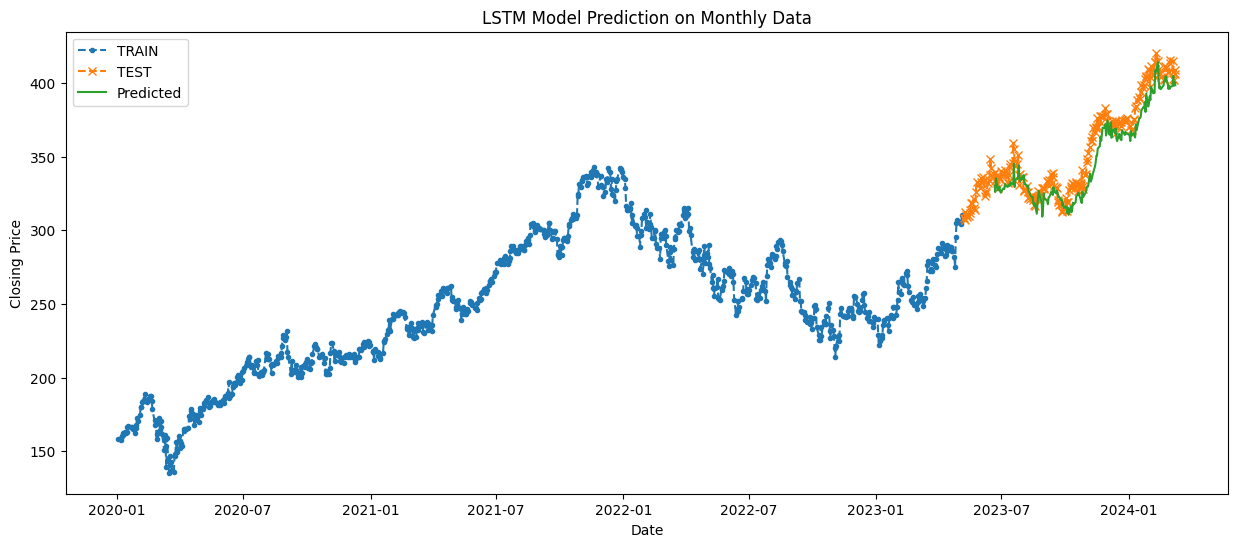

In [100]:
testPredictPlot = prediction_report(result_monthly, X, y, X_test, y_test, 30, "Monthly")

In [101]:
monthly_data = data.iloc[1:]
monthly_data['lstm_monthly'] = testPredictPlot.flatten()
monthly_data


,Open,High,Low,Close,Adj Close,Volume,lstm_monthly
Date,,,,,,,
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570129,21116200,NaN
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964508,20813700,NaN
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569809,21634100,NaN
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984039,27746500,NaN
2020-01-09,161.839996,162.220001,161.029999,162.089996,155.907745,21385000,NaN
...,...,...,...,...,...,...,...
2024-03-04,413.440002,417.350006,412.320007,414.920013,414.920013,17596000,397.884827
2024-03-05,413.959991,414.250000,400.640015,402.649994,402.649994,26919200,404.815857
2024-03-06,402.970001,405.160004,398.390015,402.089996,402.089996,22344100,398.258759


inside non daily loop


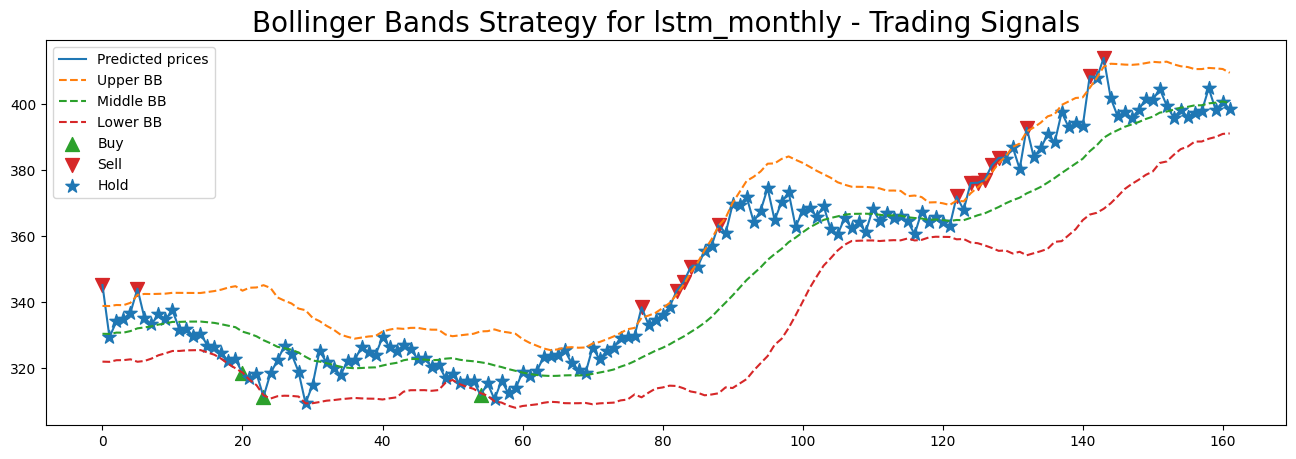

,close,predictions,B_MA,B_STD,BU,BL,Buy,Sell,Hold
0,355.079987,345.161499,330.369498,4.226397,338.822292,321.916703,NaN,345.161499,NaN
1,346.869995,329.358765,330.324039,4.232432,338.788903,321.859174,NaN,NaN,329.358765
2,343.769989,334.126343,330.728697,4.187244,339.103184,322.354210,NaN,NaN,334.126343
3,345.109985,334.898560,330.711838,4.168780,339.049397,322.374279,NaN,NaN,334.898560
4,350.980011,336.789429,331.196822,4.287737,339.772296,322.621347,NaN,NaN,336.789429
...,...,...,...,...,...,...,...,...,...
157,414.920013,397.884827,399.687325,5.493481,410.674286,388.700363,NaN,NaN,397.884827
158,402.649994,404.815857,400.277405,5.371447,411.020298,389.534511,NaN,NaN,404.815857
159,402.089996,398.258759,400.480418,5.203712,410.887842,390.072994,NaN,NaN,398.258759
160,409.140015,400.696869,400.850305,4.921668,410.693640,391.006970,NaN,NaN,400.696869


In [102]:
monthly_ans = add_signal(monthly_data, False, 20, 2, 'lstm_monthly')
monthly_ans

In [104]:
# save the built model
trained_model_file_path_for_monthly_LSTM=os.path.join("model","lstm_monthly_model.pkl")
save_object(file_path=trained_model_file_path_for_monthly_LSTM, obj=result_monthly)

### Now <u>Daily</u>:

In [105]:
# Creating LSTM for daily data

n_features = 1
n_steps = 1
X, y = prepare_data(train_data['Close'], n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

X_test, y_test = prepare_data(test_data['Close'], n_steps)

result_daily, history_daily = create_lstm(n_steps, n_features, X, y, X_test, y_test, 200)

Epoch 1/200
14/14 [==============================] - 2s 153ms/step - loss: 58369.7422 - val_loss: 107779.8594
Epoch 2/200
14/14 [==============================] - 2s 140ms/step - loss: 51434.3867 - val_loss: 92170.3359
Epoch 3/200
14/14 [==============================] - 2s 108ms/step - loss: 42690.3750 - val_loss: 72499.8828
Epoch 4/200
14/14 [==============================] - 2s 136ms/step - loss: 26093.2617 - val_loss: 18393.6875
Epoch 5/200
14/14 [==============================] - 2s 136ms/step - loss: 3885.8384 - val_loss: 27.5401
Epoch 6/200
14/14 [==============================] - 2s 115ms/step - loss: 301.2073 - val_loss: 493.6262
Epoch 7/200
14/14 [==============================] - 2s 130ms/step - loss: 98.5388 - val_loss: 36.8603
Epoch 8/200
14/14 [==============================] - 2s 134ms/step - loss: 44.3197 - val_loss: 44.4362
Epoch 9/200
14/14 [==============================] - 1s 98ms/step - loss: 27.4660 - val_loss: 24.3115
Epoch 10/200
14/14 [=========================

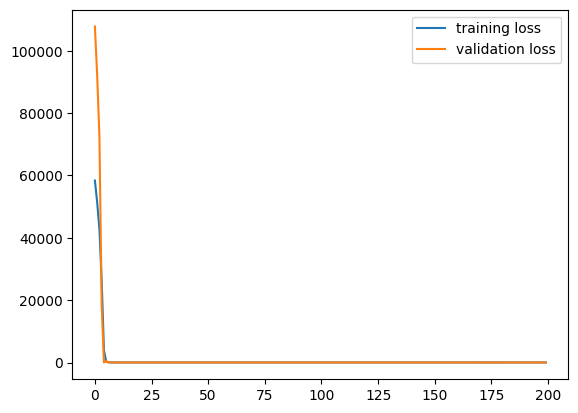

In [106]:
plot_losses(result_daily.history)

7/7 [==============================] - 1s 95ms/step


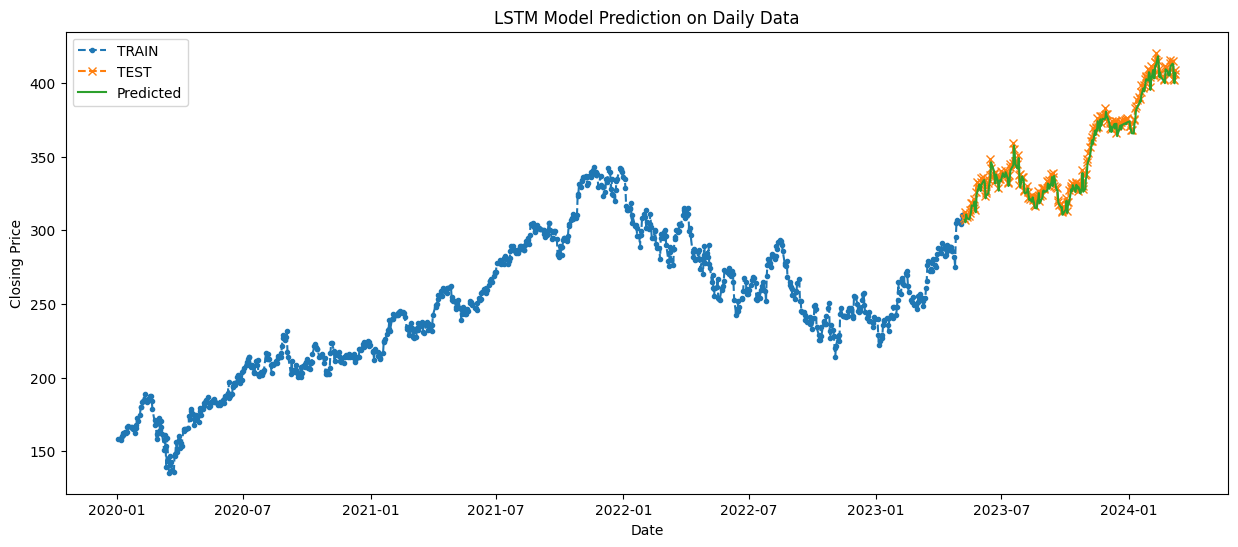

In [107]:
testPredictPlot = prediction_report(result_daily, X, y, X_test, y_test, 1, "Daily")

In [108]:
daily_data = data.iloc[1:]
daily_data['lstm_daily'] = testPredictPlot.flatten()
daily_data


,Open,High,Low,Close,Adj Close,Volume,lstm_daily
Date,,,,,,,
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570129,21116200,NaN
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964508,20813700,NaN
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569809,21634100,NaN
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984039,27746500,NaN
2020-01-09,161.839996,162.220001,161.029999,162.089996,155.907745,21385000,NaN
...,...,...,...,...,...,...,...
2024-03-04,413.440002,417.350006,412.320007,414.920013,414.920013,17596000,413.091766
2024-03-05,413.959991,414.250000,400.640015,402.649994,402.649994,26919200,412.516205
2024-03-06,402.970001,405.160004,398.390015,402.089996,402.089996,22344100,400.340240


inside daily loop


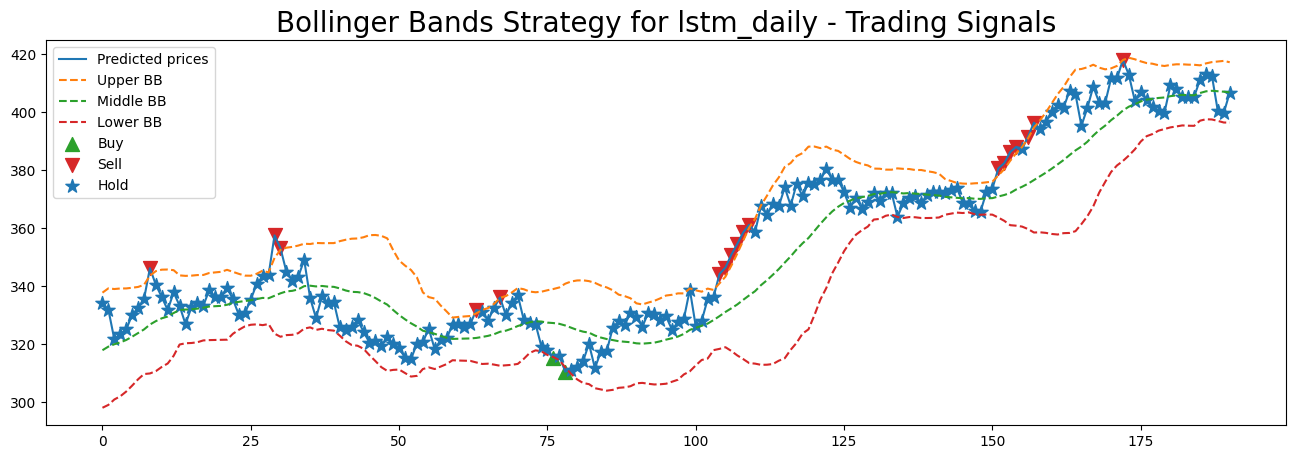

,close,predictions,B_MA,B_STD,BU,BL,Buy,Sell,Hold
0,333.679993,334.140594,317.911838,9.927836,337.767509,298.056166,NaN,NaN,334.140594
1,323.380005,331.897888,319.153748,10.051631,339.257009,299.050486,NaN,NaN,331.897888
2,325.260010,321.676727,319.966464,9.526350,339.019164,300.913765,NaN,NaN,321.676727
3,326.790009,323.542328,320.609003,9.298504,339.206010,302.011995,NaN,NaN,323.542328
4,331.850006,325.060608,321.436610,8.892564,339.221738,303.651483,NaN,NaN,325.060608
...,...,...,...,...,...,...,...,...,...
186,414.920013,413.091766,407.217139,4.815802,416.848743,397.585535,NaN,NaN,413.091766
187,402.649994,412.516205,407.400720,4.949240,417.299200,397.502240,NaN,NaN,412.516205
188,402.089996,400.340240,407.251868,5.120328,417.492523,397.011212,NaN,NaN,400.340240
189,409.140015,399.784546,407.083171,5.314198,417.711567,396.454776,NaN,NaN,399.784546


In [109]:
daily_ans = add_signal(daily_data, True, 20, 2, 'lstm_daily')
daily_ans

In [132]:
# <img src="{{ url_for('static', filename= filepath) }}" />

In [110]:
# save the built model
trained_model_file_path_for_daily_LSTM=os.path.join("model","lstm_daily_model.pkl")
save_object(file_path=trained_model_file_path_for_daily_LSTM, obj=result_daily)

## Goals:

2. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize hold period.

Capital returns are the returns on investment , ie, the calculation of profit made from trading on above signals for various time periods. The <u><i>goal of our project</u></i> is
to provide such trading advice in order to <b>maximize our capital return and minimize losses</b>.
- It can be done on the basis of calculating the difference between the bought value of the stock on buy signal and the sell value of the stock
on the sold signal. 
- And if there are only hold signals, then we can calculate on the basis of what was the starting value when you started holding the stock and 
till now or the last price of stock for which you have continued to hold.

In [111]:
def money_made(df: pd.DataFrame, duration: str):

    profit_list = []
    index_list = [0]
    
    [index_list.append(idx) for idx in df.index if df.loc[idx, 'Buy'] or df.loc[idx, 'Sell']];
    index_list.append(df.shape[0]-1)


    if df[df['Buy'] == True].shape[0] != 0 or df[df['Sell'] == True].shape[0] != 0:
      
        for j in range(len(index_list)):
            if j == len(index_list) - 1: break
            if j == len(index_list) - 2:
                start = index_list[j+1]
                end = index_list[-1]
            else:
                start = index_list[j]
                end = index_list[j+1]
                if j == len(index_list) - 2: break
                
            difference = df.loc[end, 'close'] - df.loc[start, 'close'] # last value - first value
            percent = np.round((difference/df.loc[start, 'close']) * 100, 2)
            profit_list.append(percent)
        
    # If only hold signal exists
    else:
        difference = df.loc[df.shape[0]-1, 'close'] - df.loc[0, 'close'] # last value - first value
        percent = np.round((difference/df.loc[0, 'close']) * 100, 2)
        profit_list.append(percent)
        
    print(f'The recommendations from the LSTM model on {duration} basis helped us in making the following percentage of money: {profit_list}')
    
    return profit_list

#### Capital Return for <u> daily basis </u>

In [112]:
# Calculating the capital return on the money made based on trading on daily basis

daily_return = money_made(daily_ans, "Daily") 

The recommendations from the LSTM model on Daily basis helped us in making the following percentage of money: [21.74]


#### Capital Return for <u> weekly basis </u>

In [113]:
# Calculating the capital return on the money made based on trading on weekly basis

weekly_return = money_made(weekly_ans, "Weekly") 

The recommendations from the LSTM model on Weekly basis helped us in making the following percentage of money: [20.42]


#### Capital Return for <u> monthly basis </u>

In [114]:
# Calculating the capital return on the money made based on trading on monthly basis

monthly_return = money_made(monthly_ans, "Monthly") 

The recommendations from the LSTM model on Monthly basis helped us in making the following percentage of money: [14.4]
